## IMPORTS

In [1]:
# Installer les dépendances
!pip install torch>=2.0.0 torchvision>=0.15.0 lightning>=2.0.0 torchmetrics>=0.11.4 \
hydra-core==1.3.2 hydra-colorlog==1.2.0 hydra-optuna-sweeper==1.2.0 \
mlflow opencv-python Pillow ultralytics tifffile \
rootutils pre-commit rich pytest tqdm pandas
!pip install codecarbon


In [2]:
import tifffile
import numpy as np
import cv2
import torch
import matplotlib.pyplot as plt
from ultralytics import SAM
from pathlib import Path
import torch
from codecarbon import EmissionsTracker
from datetime import datetime
import csv

In [3]:
from google.colab import drive
drive.mount('/content/drive')

# Accéder au fichier
tif_path = '/content/drive/MyDrive/Romane_Martin_urne_sature_10-4.tif'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## PARAMETRES

In [4]:

GRID_STRIDE   = 64                   # densité des points
POINTS_PER_CALL = 30                # taille des chunks envoyés à SAM
MIN_AREA      = 300                  # aire min d’un masque (en pixels)
CONF_THR      = 0.35                 #  seuil min confiance de SAM
DEDUP_IOU_THR = 0.90                 # seuil de dé-duplication
MIN_MASK_REGION_AREA = 200
IMAGE_3D_PATH = tif_path
SAM_WEIGHTS = "../data/sam_b.pt"   #path sam en local ou bien download from ultralytics
POINT_LABEL = 1


## UTILS

In [5]:
def make_grid_points(h, w, stride, label=1):
    xs = np.arange(stride // 2, w, stride)
    ys = np.arange(stride // 2, h, stride)
    pts = [(int(x), int(y)) for y in ys for x in xs]  # (x, y)
    lbls = [label] * len(pts)
    return pts, lbls

def dedup_by_iou(masks, iou_thr=0.9, min_area=0):
    keep = []
    for m in masks:
        if m.sum() < min_area:
            continue
        if any( (np.logical_and(m, k).sum() / max(np.logical_or(m, k).sum(), 1)) > iou_thr
                for k in keep ):
            continue
        keep.append(m)
    return keep


def colorize_masks(image_gray, masks_bool, seed=42):

    out = np.dstack([image_gray, image_gray, image_gray]).copy()  # [H, W, 3]
    out = out.astype(np.uint8, copy=False)
    rng = np.random.default_rng(seed)
    for m in masks_bool:
        out[m] = rng.integers(0, 256, size=3, dtype=np.uint8)  # couleur aléatoire (R,G,B)
    return out



## CHARGEMENT DONNEES & MODELE


## chargement données

In [6]:
def to_sam_handled_picture(picture_3D: np.ndarray) -> np.ndarray:
    return np.repeat(picture_3D[..., np.newaxis], 3, -1)

In [7]:
# exemple extraction slice au milieu
vol = tifffile.imread(IMAGE_3D_PATH)
print(f"Volume: shape={vol.shape}, dtype={vol.dtype}")
mid = len(vol) // 2
sl  = vol[mid]

Volume: shape=(1735, 1808, 1595), dtype=uint8


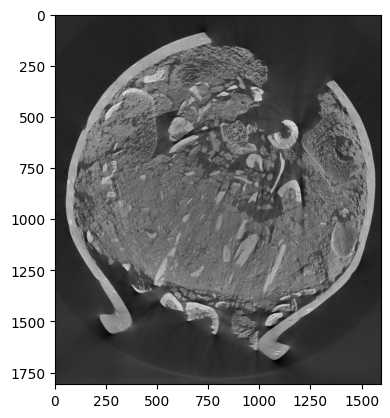

In [8]:
plt.imshow(sl, cmap="gray")
plt.show()

## chargement SAM

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")

if not Path(SAM_WEIGHTS).exists():
    print(f"Downloading {SAM_WEIGHTS}...")
    model = SAM(SAM_WEIGHTS)
else:
    print(f"{SAM_WEIGHTS} already exists locally")
    model = SAM(SAM_WEIGHTS)

print("SAM chargé")

Device: cuda
../data/sam_b.pt already exists locally
SAM chargé


## INFERENCE PAR CHUNKS DE POINTS


In [10]:
from typing import Union

def run_sam_chunked_points(model: SAM, image, points: Union[list[tuple[int, int]], int], labels=None,
                           conf=0.35, points_per_call=25, device="cpu", binarize_thr=0.5):
    img = image if image.ndim == 3 else np.dstack([image, image, image])
    # >>>> ???? >>>>
    if img.dtype != np.uint8:
        mn, mx = float(img.min()), float(img.max())
        img = ((img - mn) / (mx - mn) * 255).astype(np.uint8) if mx > mn else np.zeros_like(img, dtype=np.uint8)
    img = np.ascontiguousarray(img)
    # <<<< ???? <<<<
    masks = []
    with torch.inference_mode():
        if isinstance(points, int):
            r = model.predict(source=img, points_stride=points, points_batch_size=points_per_call, conf=conf, device=device)
            if getattr(r, "masks", None) is not None and r.masks is not None:
                t = r.masks.data  # [N,H,W]
                arr = (t > binarize_thr).cpu().numpy()
                masks.extend(mi.astype(bool) for mi in arr)
        else:
            for i in range(0, len(points), points_per_call):
                r = model.predict(source=img,
                                  points=points[i:i+points_per_call],
                                  labels=labels[i:i+points_per_call],
                                  conf=conf, device=device)[0]
                if getattr(r, "masks", None) is not None and r.masks is not None:
                    t = r.masks.data  # [N,H,W]
                    arr = (t > binarize_thr).cpu().numpy()
                    masks.extend(mi.astype(bool) for mi in arr)
        if device == "cuda":
            torch.cuda.empty_cache()
    return masks # non dédupliqués


### grille de points et inférence

In [11]:
type(sl)

numpy.ndarray

In [12]:
tracker = EmissionsTracker()
tracker.start()
H, W = sl.shape[:2]
points, labels = make_grid_points(H, W, GRID_STRIDE, label=POINT_LABEL)
print(f"Points de grille: {len(points)}  (stride={GRID_STRIDE})")

[codecarbon WARNING @ 16:13:57] Multiple instances of codecarbon are allowed to run at the same time.
[codecarbon INFO @ 16:13:57] [setup] RAM Tracking...
[codecarbon INFO @ 16:13:57] [setup] CPU Tracking...
[codecarbon WARNING @ 16:13:58] We saw that you have a Intel(R) Xeon(R) CPU @ 2.00GHz but we don't know it. Please contact us.
[codecarbon WARNING @ 16:13:58] No CPU tracking mode found. Falling back on estimation based on TDP for CPU. 
 Linux OS detected: Please ensure RAPL files exist at /sys/class/powercap/intel-rapl/subsystem to measure CPU

[codecarbon INFO @ 16:13:58] CPU Model on constant consumption mode: Intel(R) Xeon(R) CPU @ 2.00GHz
[codecarbon WARNING @ 16:13:58] No CPU tracking mode found. Falling back on CPU constant mode.
[codecarbon INFO @ 16:13:58] [setup] GPU Tracking...
[codecarbon INFO @ 16:13:58] Tracking Nvidia GPU via pynvml
[codecarbon INFO @ 16:13:58] The below tracking methods have been set up:
                RAM Tracking Method: RAM power estimation mode

Points de grille: 700  (stride=64)


In [13]:
raw_masks = run_sam_chunked_points(model, sl, points, labels, conf=CONF_THR,points_per_call=POINTS_PER_CALL, device=device)


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 1784.8ms
Speed: 138.9ms preprocess, 1784.8ms inference, 128.9ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 453.8ms
Speed: 10.9ms preprocess, 453.8ms inference, 6.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 450.3ms
Speed: 10.8ms preprocess, 450.3ms inference, 5.9ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18

[codecarbon INFO @ 16:14:13] Energy consumed for RAM : 0.000042 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:14:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:14:13] Energy consumed for All CPU : 0.000177 kWh
[codecarbon INFO @ 16:14:13] Energy consumed for all GPUs : 0.000246 kWh. Total GPU Power : 59.039632740357455 W
[codecarbon INFO @ 16:14:13] 0.000465 kWh of electricity and 0.000000 L of water were used since the beginning.


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 458.3ms
Speed: 12.8ms preprocess, 458.3ms inference, 6.1ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 455.2ms
Speed: 11.4ms preprocess, 455.2ms inference, 6.0ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 398.5ms
Speed: 11.1ms preprocess, 398.5ms inference, 2.4ms postprocess per image at shape (1, 3, 1024, 1024)


In [14]:
masks = dedup_by_iou(raw_masks, iou_thr=DEDUP_IOU_THR, min_area=MIN_AREA)
print(f" {len(masks)} masques après filtrage & dé-dup")

[codecarbon INFO @ 16:14:28] Energy consumed for RAM : 0.000083 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:14:28] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:14:28] Energy consumed for All CPU : 0.000354 kWh
[codecarbon INFO @ 16:14:28] Energy consumed for all GPUs : 0.000378 kWh. Total GPU Power : 31.721803636537878 W
[codecarbon INFO @ 16:14:28] 0.000816 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:14:43] Energy consumed for RAM : 0.000125 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:14:43] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:14:43] Energy consumed for All CPU : 0.000531 kWh
[codecarbon INFO @ 16:14:43] Energy consumed for all GPUs : 0.000495 kWh. Total GPU Power : 28.138807866052986 W
[codecarbon INFO @ 16:14:43] 0.001151 kWh of electricity and 0.000000 L of water were used since the beginning.
[codecarbon INFO @ 16:

 281 masques après filtrage & dé-dup


## SAVE VISUALISATION

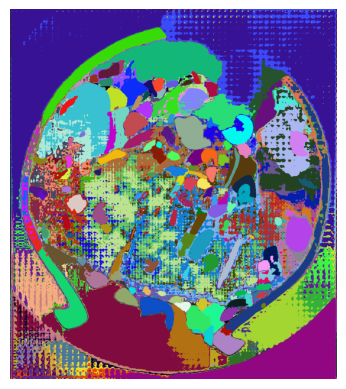

 Sauvegarde: sam_colored_slice_867.png


In [15]:

if len(masks) == 0:
    print(" Aucun objet détecté ")
else:
    masks_sorted = sorted(masks, key=lambda x: x.sum(), reverse=True)
    colored = colorize_masks(sl, masks_sorted, seed=0)
    plt.imshow(colored)
    plt.axis("off")
    plt.show()
    cv2.imwrite(f"sam_colored_slice_{mid}.png", colored)
    print(f" Sauvegarde: sam_colored_slice_{mid}.png")


## Segmentation avec bounding box


In [2]:
def make_grid_boxes(h, w, stride, box_size=64):
    xs = np.arange(stride // 2, w, stride)
    ys = np.arange(stride // 2, h, stride)
    boxes = []
    for y in ys:
        for x in xs:
            x1 = max(0, x - box_size // 2)
            y1 = max(0, y - box_size // 2)
            x2 = min(w, x + box_size // 2)
            y2 = min(h, y + box_size // 2)
            boxes.append([x1, y1, x2, y2])
    return boxes

def run_sam_chunked_boxes(model: SAM, image, boxes, conf=0.35, boxes_per_call=25, device="cpu", binarize_thr=0.5):
    img = image if image.ndim == 3 else np.dstack([image, image, image])
    if img.dtype != np.uint8:
        mn, mx = float(img.min()), float(img.max())
        img = ((img - mn) / (mx - mn) * 255).astype(np.uint8) if mx > mn else np.zeros_like(img, dtype=np.uint8)
    img = np.ascontiguousarray(img)

    masks = []
    with torch.inference_mode():
        for i in range(0, len(boxes), boxes_per_call):
            r = model.predict(source=img,
                              bboxes=boxes[i:i+boxes_per_call],
                              conf=conf, device=device)[0]
            if getattr(r, "masks", None) is not None and r.masks is not None:
                t = r.masks.data
                arr = (t > binarize_thr).cpu().numpy()
                masks.extend(mi.astype(bool) for mi in arr)
        if device == "cuda":
            torch.cuda.empty_cache()
    return masks


## Analyse de l'IOU entre Slices


In [3]:
# Tracking d'objets entre slices
# we consider a binary mask
def match_masks_between_slices(masks_prev, masks_curr, iou_threshold=0.3):
    # combiner les masques dans un seul mask binaire
    mask_prev_combined = np.zeros_like(masks_prev[0])
    for mask in masks_prev:
        mask_prev_combined |= mask

    # combiner les masques dans un seul mask binaire
    mask_curr_combined = np.zeros_like(masks_curr[0])
    for mask in masks_curr:
        mask_curr_combined |= mask

        # calculer l'IOU entre les deux masks combinées
    intersection = np.logical_and(mask_prev_combined, mask_curr_combined)
    union = np.logical_or(mask_prev_combined, mask_curr_combined)
    iou = np.sum(intersection) / np.sum(union)

    return iou

In [17]:
# generating multi slice segmentation
print(f"Volume: shape={vol.shape}, dtype={vol.dtype}")


Volume: shape=(1735, 1808, 1595), dtype=uint8


In [ ]:
# Calculate the iou for 10 middle slices
slice_beginning = mid - 10
slice_end = mid + 10
iou_values = []

points, labels = make_grid_points(H, W, GRID_STRIDE, label=POINT_LABEL)

for i in range(slice_beginning, slice_end):
    print(f"Slice{i - slice_beginning}")
    masks_prev = run_sam_chunked_points(model, vol[i], points, labels, conf=CONF_THR,points_per_call=POINTS_PER_CALL, device=device)
    masks_curr = run_sam_chunked_points(model, vol[i+1], points, labels, conf=CONF_THR,points_per_call=POINTS_PER_CALL, device=device)
    iou = match_masks_between_slices(masks_prev, masks_curr)
    iou_values.append(iou)


# printing ious using different grids
print("using point grids\n")
print(iou_values)



Slice0

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 573.0ms
Speed: 10.1ms preprocess, 573.0ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 505.5ms
Speed: 12.6ms preprocess, 505.5ms inference, 6.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 501.3ms
Speed: 15.0ms preprocess, 501.3ms inference, 6.5ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 

[codecarbon INFO @ 16:20:13] Energy consumed for RAM : 0.001041 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:20:13] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:20:13] Energy consumed for All CPU : 0.004424 kWh
[codecarbon INFO @ 16:20:13] Energy consumed for all GPUs : 0.003323 kWh. Total GPU Power : 47.25564504976647 W
[codecarbon INFO @ 16:20:13] 0.008788 kWh of electricity and 0.000000 L of water were used since the beginning.


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 9, 1 10, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 512.2ms
Speed: 10.0ms preprocess, 512.2ms inference, 6.2ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 22, 1 23, 1 24, 1 25, 1 27, 1 28, 1 29, 515.9ms
Speed: 9.9ms preprocess, 515.9ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 17, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 509.5ms
Speed: 11.7ms preprocess, 509.5ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 27, 1 28, 1 29, 51

[codecarbon INFO @ 16:20:28] Energy consumed for RAM : 0.001082 kWh. RAM Power : 10.0 W
[codecarbon INFO @ 16:20:28] Delta energy consumed for CPU with constant : 0.000177 kWh, power : 42.5 W
[codecarbon INFO @ 16:20:28] Energy consumed for All CPU : 0.004601 kWh
[codecarbon INFO @ 16:20:28] Energy consumed for all GPUs : 0.003604 kWh. Total GPU Power : 67.42582536366918 W
[codecarbon INFO @ 16:20:28] 0.009288 kWh of electricity and 0.000000 L of water were used since the beginning.


0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 530.6ms
Speed: 10.6ms preprocess, 530.6ms inference, 6.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 9, 1 10, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 535.8ms
Speed: 10.5ms preprocess, 535.8ms inference, 6.3ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 12, 1 13, 1 14, 1 15, 1 16, 1 17, 1 18, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26, 1 27, 1 28, 1 29, 543.9ms
Speed: 9.8ms preprocess, 543.9ms inference, 6.4ms postprocess per image at shape (1, 3, 1024, 1024)

0: 1024x1024 1 0, 1 1, 1 2, 1 3, 1 4, 1 5, 1 6, 1 7, 1 8, 1 9, 1 10, 1 11, 1 13, 1 14, 1 15, 1 17, 1 19, 1 20, 1 21, 1 22, 1 23, 1 24, 1 25, 1 26

In [4]:
## AVEC BOUNDING BOX

iou_values_boxes = []
boxes = make_grid_boxes(H, W, GRID_STRIDE, box_size=64)

for i in range(slice_beginning, slice_end):
    print(f"[Boxes] Slice {i - slice_beginning}")
    masks_prev = run_sam_chunked_boxes(model, vol[i], boxes, conf=CONF_THR, boxes_per_call=POINTS_PER_CALL, device=device)
    masks_curr = run_sam_chunked_boxes(model, vol[i+1], boxes, conf=CONF_THR, boxes_per_call=POINTS_PER_CALL, device=device)
    iou = match_masks_between_slices(masks_prev, masks_curr)
    iou_values_boxes.append(iou)

print("\nUsing bounding boxes:\n")
print(iou_values_boxes)


In [5]:
## IOU comparaison between points grid and bounding boxes
mean_iou_points = np.mean(iou_values)
mean_iou_boxes  = np.mean(iou_values_boxes)

print(f"\nMoyenne IoU (points): {mean_iou_points:.4f}")
print(f"Moyenne IoU (boxes) : {mean_iou_boxes:.4f}")

plt.figure()
plt.plot(iou_values, label="Points grid")
plt.plot(iou_values_boxes, label="Bounding boxes")
plt.xlabel("Slice index")
plt.ylabel("IoU")
plt.legend()
plt.title("Comparaison IoU entre slices (points vs boxes)")
plt.show()


### WRITE CODECARBONE RESULTS AND STOP TRACKER

In [ ]:
emissions= tracker.stop()
with open("emissions.csv", "a", newline="") as f:
    writer = csv.writer(f)
    timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S")
    writer.writerow([timestamp, emissions])
